# Hands-on introduction to PINNs

The tutorial provides code that follows the intuitive guide about PINNs found at the link https://towardsdatascience.com/physics-informed-neural-networks-pinns-an-intuitive-guide-fff138069563. As reference for the implementation the code example from https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb was used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_loss(iterations, history_loss_train, history_loss_test):
    epochs = np.arange(0, iterations, 1)
    plt.plot(epochs, history_loss_train, label='loss')
    plt.plot(epochs, history_loss_test, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error (Loss)')
    plt.legend()
    plt.grid(True)

### 0. Generate data: Ground truth (GT) and realistic training data 

Projectile motion is a form of motion experienced by an object or particle (a projectile) that is projected in a gravitational field. <br>
Formula for calculating the **displacement** of the projectile <br>
$ x = v_0 cos(\theta) t $ <br>
$ y = v_0 sin(\theta) t - \frac{1}{2} g t^2 $ <br>
source: https://en.wikipedia.org/wiki/Projectile_motion

In [3]:
def projectile_motion(v0, theta, t_end, dt):
    g = 9.81  #m/s^2, gravity

    theta_rad = np.radians(theta) # convert launch angle from degrees to radians

    # sampling points
    time_points = np.arange(0, t_end + dt, dt)
    x_points = []
    y_points = []

    for t in time_points:
        # Calculate the horizontal and vertical displacement at time t
        x = v0 * np.cos(theta_rad) * t
        y = v0 * np.sin(theta_rad) * t - 0.5 * g * t**2

        x_points.append(x)
        y_points.append(y)

    return x_points, y_points, time_points

In [4]:
# Initial conditions (IC)
v0 = 20.0  # Initial velocity (m/s)
theta = 30.0  # Launch angle in degrees
t_end = 2.0  # Total time for the simulation (s)
dt = 0.04  # Time step for each sampling point (s)

# Generate the trajectory under defined IC
x_simple, y_simple, time_simple = projectile_motion(v0, theta, t_end, dt)

In [ ]:
# Visualize the trajectory of the projectile
plt.figure(figsize=(15,4))
plt.plot(x_simple, y_simple)
plt.scatter(x_simple, y_simple, s= 3, c='red')
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

**Trajectory of a projectile with air resistance**: <br>
Air resistance creates a force that (for symmetric projectiles) is always directed against the direction of motion in the surrounding medium and has a magnitude that depends on the absolute speed. <br>
Formula for calculating the **displacement** of the projectile with drag: <br>
$ x = \frac{v_0 cos(\theta)}{\mu} (1-e^{-\mu t}) $ <br>
$ y = - \frac{g}{\mu}t+ \frac{1}{\mu} (v_0 sin(\theta)+\frac{g}{\mu})(1-e^{-\mu t}) $ <br>
source: https://en.wikipedia.org/wiki/Projectile_motion

In [6]:
def projectile_motion_with_drag(v0, theta, t_end, dt):
    g = 9.81  # m/s^2, gravity

    theta_rad = np.radians(theta) # convert launch angle from degrees to radians

    # sampling points
    time_points = np.arange(0, t_end + dt, dt)
    x_points = []
    y_points = []
    mu = 0.1

    for t in time_points:
        # Calculate the horizontal and vertical displacement at time t
        x = v0*np.cos(theta_rad)/mu*(1-np.exp(-mu*t))
        y = -g/mu*t+1/mu*(v0*np.sin(theta_rad)+g/mu)*(1-np.exp(-mu*t))

        x_points.append(x)
        y_points.append(y)

    return x_points, y_points, time_points

In [7]:
# Initial conditions (IC)
v0 = 20.0  # Initial velocity (m/s)
theta = 30.0  # Launch angle in degrees
t_end = 2.0  # Total time for the simulation (s)
dt = 0.04  # Time step for each sampling point (s)

# Generate the trajectory under defined IC
x_drag, y_drag, time_drag = projectile_motion_with_drag(v0, theta, t_end, dt)

In [8]:
## Generate more realistic data (sparse, incomplete, noisy)
len_new = round(len(x_drag)/3)
x_drag_new = x_drag[:len_new]
y_drag_new = y_drag[:len_new]
time_train = time_drag[:len_new]
# add white noise (with mean 0 and standard deviation 1)
np.random.seed(26)
noise = np.random.randn(len(x_drag_new))  
noise_level = 0.2
x_train = x_drag_new + noise_level * noise
noise = np.random.randn(len(y_drag_new))
noise_level = 0.1
y_train = y_drag_new + noise_level * noise

In [ ]:
# Plot the trajectory
plt.figure(figsize=(15,4))
plt.plot(x_simple, y_simple)
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(x_train, y_train, s= 3, c='green')
plt.legend(["GT without drag", "GT", "realistic training data"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

state of the projectile

In [10]:
vx_drag = np.gradient(x_drag, dt)
vy_drag = np.gradient(y_drag, dt)

ax_drag = np.gradient(vx_drag, dt)
ay_drag = np.gradient(vy_drag, dt)

In [ ]:
plt.figure(figsize=(15,4))
#plt.plot(x_simple, y_simple)
plt.plot(time_drag, vx_drag)
plt.plot(time_drag, vy_drag)
plt.plot(time_drag, np.sqrt(vx_drag**2+vy_drag**2))
#plt.scatter(x_train, y_train, s= 3, c='green')
plt.legend(["vx", "vy", "|v|"])
plt.xlabel('time in s')
plt.ylabel('v in m/s')
plt.grid(True)
#plt.axis('equal')
plt.show()

plt.figure(figsize=(15,4))
#plt.plot(x_simple, y_simple)
plt.plot(time_drag, ax_drag)
plt.plot(time_drag, ay_drag)
plt.plot(time_drag, np.sqrt(ax_drag**2+ay_drag**2))
#plt.scatter(x_train, y_train, s= 3, c='green')
plt.legend(["ax", "ay", "|a|"])
plt.xlabel('time in s')
plt.ylabel('a in m/s^2')
plt.grid(True)
#plt.axis('equal')
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
dtime_drag = np.diff(time_drag)
plt.plot(np.cumsum(vx_drag[:-1]) * dtime_drag, np.cumsum(vy_drag[1:])* dtime_drag)
plt.plot(x_drag, y_drag)
#plt.plot(time_drag, 1/2*np.sqrt(ax**2+ay**2)*time_drag**2)
plt.legend(["a_train", "a_pred"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.grid(True)
#plt.axis('equal')
plt.show()

plt.figure(figsize=(15,4))
dtime_drag = np.diff(time_drag)
plt.plot(np.cumsum(np.cumsum(ax_drag[:-1]) * dtime_drag + 17.28) * dtime_drag, np.cumsum(np.cumsum(ay_drag[:-1]) * dtime_drag+ 9.78) * dtime_drag)
plt.plot(x_drag, y_drag)
#plt.plot(time_drag, 1/2*np.sqrt(ax**2+ay**2)*time_drag**2)
plt.legend(["a_train", "a_pred"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.grid(True)
#plt.axis('equal')
plt.show()

### 1. Artificial Neural Network (ANN)

In [13]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.hidden_layer1 = nn.Linear(1,30)
        self.hidden_layer2 = nn.Linear(30,30)
        self.output_layer = nn.Linear(30,2)

    def forward(self, t):
        inputs = torch.Tensor(t) 
        layer1_out = nn.functional.gelu(self.hidden_layer1(inputs))
        layer2_out = nn.functional.gelu(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out)
        return output
    
net_ANN = ANN()
net_ANN = net_ANN.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_ANN.parameters())

In [ ]:
### Training

# training data
s_train = Variable(torch.from_numpy(np.array([x_train, y_train])).float(), requires_grad=True).to(device)
s_train = s_train.T
t_train = Variable(torch.from_numpy(time_train).float(), requires_grad=True).to(device)
t_train = t_train.reshape(-1,1)
s_test = Variable(torch.from_numpy(np.array([x_drag, y_drag])).float(), requires_grad=True).to(device)
s_test = s_test.T
t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

iterations = 10000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on training error
    s = net_ANN(t_train)
    loss_train = loss_function(s, s_train)
    
    # Combining the loss functions
    loss = loss_train
    
    loss.backward()
    optimizer.step() 
    
    # Loss history
    history_loss_train.append(loss.item())
    s = net_ANN(t)
    loss_test = loss_function(s, s_test)
    history_loss_test.append(loss_test.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)
            
    # Early stopping
    if prev_loss - loss.item() <= 0.000001: 
        loss_count += 1
        #if loss_count == 1000:
            #print("callback due to early stopping")
            #iterations = epoch+1
            #break
    prev_loss = loss.item()

s_train = s_train.data.cpu().numpy()
sx_train = s_train[:,0]
sy_train = s_train[:,1]

In [ ]:
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing

# testing data
t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

s = net_ANN(t)

s=s.data.cpu().numpy()
sx = s[:,0]
sy = s[:,1]

plt.figure(figsize=(15,4))
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(sx_train, sy_train, s = 3, c = 'green')
plt.plot(sx, sy, c = 'orange')
plt.legend(["GT",  "training data", "estimation"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

Conclusion: 
- ANN is not able to correctly extrapolate 
- Overfitting visible (-> enable early stopping in the code to reduce overfitting)

### 2. Artificial Neural Network (ANN) with regularization

In [17]:
net_ANN2 = ANN()
net_ANN2 = net_ANN2.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_ANN2.parameters())

In [ ]:
### Training

# training data
s_train = Variable(torch.from_numpy(np.array([x_train, y_train])).float(), requires_grad=True).to(device)
s_train = s_train.T
t_train = Variable(torch.from_numpy(time_train).float(), requires_grad=True).to(device)
t_train = t_train.reshape(-1,1)
s_test = Variable(torch.from_numpy(np.array([x_drag, y_drag])).float(), requires_grad=True).to(device)
s_test = s_test.T
t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

iterations = 20000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on training error
    s = net_ANN2(t_train)
    loss_train = loss_function(s, s_train)
    
    # loss from L2 regularization
    lambda_reg = 0.001
    loss_reg = lambda_reg * sum(w.norm() ** 2 for w in net_ANN2.parameters())
    
    # Combining the loss functions
    loss = loss_train + loss_reg
    
    loss.backward()
    optimizer.step()
    
    # Loss history
    history_loss_train.append(loss.item())
    s = net_ANN2(t)
    loss_test = loss_function(s, s_test)
    history_loss_test.append(loss_test.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)
    
    # Early stopping
    if prev_loss - loss.item() <= 0.00001: 
        loss_count += 1
        if loss_count == 1000:
            print("callback due to early stopping")
            iterations = epoch+1
            break
    prev_loss = loss.item()

s_train = s_train.data.cpu().numpy()
sx_train = s_train[:,0]
sy_train = s_train[:,1]

In [ ]:
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing

# testing data
t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

s = net_ANN2(t)

s=s.data.cpu().numpy()
sx = s[:,0]
sy = s[:,1]

plt.figure(figsize=(15,4))
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(sx_train, sy_train, s = 3, c = 'green')
plt.plot(sx, sy, c = 'orange')
plt.legend(["GT", "training data", "estimation"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

Conclusion:
- Regularization reduces overfitting

### 3. Physical Informed Neural Network (PINN)

In [21]:
net_PINN = ANN()
net_PINN = net_PINN.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_PINN.parameters())

In [22]:
## Differential Equation
def f_phys(s, t):
    sx = s[:, 0]
    sy = s[:, 1]
    mu = 0.01 # real 0.1
    g = torch.Tensor([[0.0, 9.81]])

    vx = torch.autograd.grad(sx.sum(), t, create_graph=True)[0]
    ax = torch.autograd.grad(vx.sum(), t, create_graph=True)[0]
    vy = torch.autograd.grad(sy.sum(), t, create_graph=True)[0]
    ay = torch.autograd.grad(vy.sum(), t, create_graph=True)[0]
    v = torch.cat((vx, vy),1)
    a = torch.cat((ax, ay),1)
    speed = torch.norm(v, dim=1, keepdim=True)
    return -mu * speed * v - g - a

In [ ]:
### Training

# training data
s_train = Variable(torch.from_numpy(np.array([x_train, y_train])).float(), requires_grad=True).to(device)
s_train = s_train.T
t_train = Variable(torch.from_numpy(time_train).float(), requires_grad=True).to(device)
t_train = t_train.reshape(-1,1)
s_test = Variable(torch.from_numpy(np.array([x_drag, y_drag])).float(), requires_grad=True).to(device)
s_test = s_test.T

t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

iterations = 10000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on training error
    s = net_PINN(t_train)
    loss_train = loss_function(s, s_train)

    # Loss based on physical equation
    s = net_PINN(t)
    loss_phys = torch.mean(torch.square(f_phys(s, t)))

    # Combining the loss functions
    loss = loss_train + loss_phys
    loss.backward()
    optimizer.step() 
    
    # Loss history
    history_loss_train.append(loss.item())
    loss_test = loss_function(s, s_test)
    history_loss_test.append(loss_test.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)
            
    # Early stopping
    if prev_loss - loss.item() <= 0.00001: 
        loss_count += 1
        if loss_count == 1000:
            print("callback due to early stopping")
            iterations = epoch+1
            break
    prev_loss = loss.item()

s_train=s_train.data.cpu().numpy()
sx_train = s_train[:,0]
sy_train = s_train[:,1]

In [ ]:
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing
s = net_PINN(t)
s=s.data.cpu().numpy()
sx = s[:,0]
sy = s[:,1]

plt.figure(figsize=(15,4))
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(sx_train, sy_train, s = 3, c = 'green')
plt.plot(sx, sy, c = 'orange')
plt.legend(["GT", "training data", "estimation"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

Conclusion:
- PINN is able to extrapolate
- Overfitting is reduced

### 4. Physical Informed Neural Network (PINN) with learning unkown parameters

reference: https://towardsdatascience.com/differential-equations-as-a-pytorch-neural-network-layer-7614ba6d587f

In [26]:
net_PINN2 = ANN()
net_PINN2 = net_PINN2.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_PINN2.parameters())

In [27]:
# Differential equation with learnable parameters
class DE(nn.Module):
    def __init__(self, 
                 mu: float,
                 ):
        super().__init__() 
        self.mu = torch.nn.Parameter(torch.tensor(mu)) # make mu a learnable parameter
        
    def forward(self, 
                s: torch.TensorType, 
                t: float, 
                ) -> torch.Tensor: 
        sx = s[:, 0]
        sy = s[:, 1]
        g = torch.Tensor([[0.0, 9.81]])
        vx = torch.autograd.grad(sx.sum(), t, create_graph=True)[0]
        ax = torch.autograd.grad(vx.sum(), t, create_graph=True)[0]
        vy = torch.autograd.grad(sy.sum(), t, create_graph=True)[0]
        ay = torch.autograd.grad(vy.sum(), t, create_graph=True)[0]
        v = torch.cat((vx, vy),1)
        a = torch.cat((ax, ay),1)
        speed = torch.norm(v, dim=1, keepdim=True)
        return  -self.mu * speed * v - g - a

f_phys_mu = DE(mu = 2.0)
optimizer_phys = torch.optim.Adam(f_phys_mu.parameters(), lr = 0.0005)

In [ ]:
### Training

# training data
s_train = Variable(torch.from_numpy(np.array([x_train, y_train])).float(), requires_grad=True).to(device)
s_train = s_train.T
t_train = Variable(torch.from_numpy(time_train).float(), requires_grad=True).to(device)
t_train = t_train.reshape(-1,1)
s_test = Variable(torch.from_numpy(np.array([x_drag, y_drag])).float(), requires_grad=True).to(device)
s_test = s_test.T

t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

iterations = 3000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on training error
    s = net_PINN2(t_train)
    loss_train = loss_function(s, s_train)

    # Loss based on physical equation
    s = net_PINN2(t)
    loss_phys = torch.mean(torch.square(f_phys_mu(s, t)))

    # Combining the loss functions
    loss = loss_train + 0.0001*loss_phys

    loss.backward()
    optimizer.step() 
    optimizer_phys.step()
    
    # Loss history
    history_loss_train.append(loss.item())
    loss_test = loss_function(s, s_test)
    history_loss_test.append(loss_test.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)
            
    # Early stopping
    if prev_loss - loss.item() <= 0.00001: 
        loss_count += 1
        if loss_count == 1000:
            print("callback due to early stopping")
            iterations = epoch+1
            break
    prev_loss = loss.item()

s_train=s_train.data.cpu().numpy()
sx_train = s_train[:,0]
sy_train = s_train[:,1]

In [ ]:
print(f_phys_mu.mu)
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing
s = net_PINN2(t)
s=s.data.cpu().numpy()
sx = s[:,0]
sy = s[:,1]

plt.figure(figsize=(15,4))
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(sx_train, sy_train, s = 3, c = 'green')
plt.plot(sx, sy, c = 'orange')
plt.legend(["GT", "training data", "estimation"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

Conclusion:
- training data is not sufficient to determine $\mu$
- principle shown

Now: Training data for the entire observed time span

In [31]:
# new training data
np.random.seed(26)
noise = np.random.randn(len(x_drag))  
noise_level = 0.2
x_train2 = x_drag + noise_level * noise
noise = np.random.randn(len(y_drag))
noise_level = 0.1
y_train2 = y_drag + noise_level * noise

In [32]:
net_PINN3 = ANN()
net_PINN3 = net_PINN3.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_PINN3.parameters())

f_phys_mu2 = DE(mu = 1.5)
optimizer_phys = torch.optim.Adam(f_phys_mu2.parameters(), lr = 0.0005)

In [ ]:
### Training

# training data
s_train = Variable(torch.from_numpy(np.array([x_train2, y_train2])).float(), requires_grad=True).to(device)
s_train = s_train.T
t_train = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t_train = t_train.reshape(-1,1)
s_test = Variable(torch.from_numpy(np.array([x_drag, y_drag])).float(), requires_grad=True).to(device)
s_test = s_test.T

t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

iterations = 5400
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on training error
    s = net_PINN3(t_train)
    loss_train = loss_function(s, s_train)

    # Loss based on physical equation
    s = net_PINN3(t)
    loss_phys = torch.mean(torch.square(f_phys_mu2(s, t)))

    # Combining the loss functions
    loss = loss_train + loss_phys

    loss.backward()
    optimizer.step() 
    optimizer_phys.step()
    
    # Loss history
    history_loss_train.append(loss.item())
    loss_test = loss_function(s, s_test)
    history_loss_test.append(loss_test.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)
            
    # Early stopping
    if prev_loss - loss.item() <= 0.0001: 
        loss_count += 1
        if loss_count == 1000:
            print("callback due to early stopping")
            iterations = epoch+1
            break
    prev_loss = loss.item()         

s_train=s_train.data.cpu().numpy()
sx_train = s_train[:,0]
sy_train = s_train[:,1]

In [ ]:
# true mu = 0.1
print(f_phys_mu2.mu)
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing
s = net_PINN3(t)
s=s.data.cpu().numpy()
sx = s[:,0]
sy = s[:,1]

plt.figure(figsize=(15,4))
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(sx_train, sy_train, s = 3, c = 'green')
plt.plot(sx, sy, c = 'orange')
plt.legend(["GT", "training data", "estimation"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

### 5. PINN as surrogate model 

In [36]:
net_PINN4 = ANN()
net_PINN4 = net_PINN4.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_PINN4.parameters())

In [ ]:
### Training

# training data
s_train = Variable(torch.from_numpy(np.array([x_train2, y_train2])).float(), requires_grad=True).to(device)
s_train = s_train.T
t_train = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t_train = t_train.reshape(-1,1)

t = Variable(torch.from_numpy(time_drag).float(), requires_grad=True).to(device)
t = t.reshape(-1,1)

# BC
s_bc0 = Variable(torch.from_numpy(np.array([0,0])).float(), requires_grad=False).to(device)
t_bc0 = Variable(torch.from_numpy(np.array([0])).float(), requires_grad=False).to(device)
theta0 = 30
v0 = 20
t1 = 0.04
mu = 0.1
g = 9.81
sx1 = v0*np.cos(np.radians(theta0))/mu*(1-np.exp(-mu*t1))
sy1 = -g/mu*t1+1/mu*(v0*np.sin(np.radians(theta0))+g/mu)*(1-np.exp(-mu*t1))
s_bc1 = Variable(torch.from_numpy(np.array([sx1, sy1])).float(), requires_grad=False).to(device)
t_bc1 = Variable(torch.from_numpy(np.array([t1])).float(), requires_grad=False).to(device)

iterations = 4000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    s0 = net_PINN4(t_bc0) # output of u(x,t)
    loss_bc0 = loss_function(s0, s_bc0)
    
    s1 = net_PINN4(t_bc1)
    loss_bc1 = loss_function(s1, s_bc1)

    # Loss based on physical equation
    s = net_PINN4(t)
    loss_phys = torch.mean(torch.square(f_phys(s, t)))
    
    # Combining the loss functions
    loss = loss_bc0 + loss_bc1 + loss_phys

    loss.backward()
    optimizer.step()
    
    # Loss history
    history_loss_train.append(loss.item())
    loss_test = loss_function(s, s_train)
    history_loss_test.append(loss_test.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)

    # Early stopping
    if prev_loss - loss.item() <= 0.0000001: 
        loss_count += 1
        if loss_count == 1000:
            print("callback due to early stopping")
            iterations = epoch+1
            break
    prev_loss = loss.item()  

s_train=s_train.data.cpu().numpy()
sx_train = s_train[:,0]
sy_train = s_train[:,1]

In [ ]:
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing
s = net_PINN4(t)
s=s.data.cpu().numpy()
sx = s[:,0]
sy = s[:,1]

plt.figure(figsize=(15,4))
plt.plot(x_drag, y_drag, c = 'green')
plt.scatter(sx_train, sy_train, s = 3, c = 'green')
plt.plot(sx, sy, c = 'orange')
plt.legend(["GT", "training data", "estimation"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.title('Projectile Motion Trajectory')
plt.grid(True)
plt.axis('equal')
plt.show()

### 6. State-based PINN 

In [40]:
class ANN_state(nn.Module):
    def __init__(self):
        super(ANN_state, self).__init__()
        self.hidden_layer1 = nn.Linear(2,10)
        self.hidden_layer2 = nn.Linear(10,10)
        self.output_layer = nn.Linear(10,2)

    def forward(self, t):
        inputs = torch.Tensor(t) 
        layer1_out = nn.functional.gelu(self.hidden_layer1(inputs))
        layer2_out = nn.functional.gelu(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out)
        return output
    
net_PINN5 = ANN_state()
net_PINN5 = net_PINN5.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_PINN5.parameters())

In [41]:
# Differential equation with learnable parameters
class DE(nn.Module):
    def __init__(self):
        super().__init__() 
        self.mu = 0.1 #torch.nn.Parameter(torch.tensor(mu)) # make mu a learnable parameter
        
    def forward(self, 
                a: torch.TensorType, 
                v: torch.TensorType, 
                ) -> torch.Tensor: 
        ax = a[:, 0]
        ay = a[:, 1]
        vx = v[:, 0]
        vy = v[:, 1]
        
        ax_v = torch.autograd.grad(ax.sum(), v, retain_graph=True)[0]
        ay_v = torch.autograd.grad(ay.sum(), v, retain_graph=True)[0]
        ax_vx = ax_v[:,0]
        ax_vy = ax_v[:,1]
        ay_vx = ay_v[:,0]
        ay_vy = ay_v[:,1]
        #print(ax_v.size(), ay_v.size())
        
        ax_vx2 = -self.mu*(2*vx**2+vy**2)/torch.sqrt(vx**2+vy**2)
        #ax_vx2 = -self.mu*(torch.multiply(2,torch.square(vx))+torch.square(vy))/torch.sqrt(torch.square(vx)+torch.square(vy))
        ax_vy2 = -self.mu*vy*vx/torch.sqrt(torch.square(vx)+torch.square(vy))
        ay_vx2 = -self.mu*vy*vx/torch.sqrt(torch.square(vx)+torch.square(vy))
        ay_vy2 = -self.mu*(torch.multiply(2,torch.square(vy))+torch.square(vx))/torch.sqrt(torch.square(vx)+torch.square(vy))
        
        return torch.mean(torch.square(ax_vx2-ax_vx)+torch.square(ax_vy2-ax_vy)+torch.square(ay_vx2-ay_vx)+torch.square(ay_vy2-ay_vy))

f_phys_state = DE()
#optimizer_phys = torch.optim.Adam(f_state_mu.parameters(), lr = 0.0005)

In [ ]:
### Training

# training data
a_train = Variable(torch.from_numpy(np.array([ax_drag, ay_drag])).float(), requires_grad=True).to(device)
a_train = a_train.T
v_train = Variable(torch.from_numpy(np.array([vx_drag, vy_drag])).float(), requires_grad=True).to(device)
v_train = v_train.T

iterations = 20000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on training error
    a = net_PINN5(v_train)
    loss_train = loss_function(a, a_train)

    # Loss based on physical equation
    loss_phys = f_phys_state(a, v_train)

    # Combining the loss functions
    loss = loss_train + loss_phys

    loss.backward()
    optimizer.step() 
    
    # Loss history
    history_loss_train.append(loss.item())
    history_loss_test.append(loss_train.item())

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)
            
    # Early stopping
    if prev_loss - loss.item() <= 0.0000001: 
        loss_count += 1
        #if loss_count == 1000:
        #    print("callback due to early stopping")
        #    iterations = epoch+1
        #    break
    prev_loss = loss.item() 

a_train=a_train.data.cpu().numpy()
ax_train = a_train[:,0]
ay_train = a_train[:,1]

In [ ]:
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing

a = net_PINN5(v_train)
a=a.data.cpu().numpy()
ax = a[:,0]
ay = a[:,1]

plt.figure(figsize=(15,4))
plt.plot(time_drag, np.sqrt(ax_train**2+ay_train**2))
plt.plot(time_drag, np.sqrt(ax**2+ay**2))
plt.legend(["a_train", "a_pred"])
plt.xlabel('time in s')
plt.ylabel('v in m/s')
plt.grid(True)
#plt.axis('equal')
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
dtime_drag = np.diff(time_drag)
plt.plot(np.cumsum(np.cumsum(ax_train[:-1]) * dtime_drag + 17.28) * dtime_drag, np.cumsum(np.cumsum(ay_train[:-1]) * dtime_drag+ 9.78) * dtime_drag)
plt.plot(x_drag, y_drag)
#plt.plot(time_drag, 1/2*np.sqrt(ax**2+ay**2)*time_drag**2)
plt.legend(["a_train", "a_pred"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.grid(True)
#plt.axis('equal')
plt.show()

### 7. State-based PINN with minimum amount of training data (as BC)

In [46]:
net_PINN6 = ANN_state()
net_PINN6 = net_PINN6.to(device)

loss_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net_PINN6.parameters())

In [ ]:
### Training

# training data
a_train = Variable(torch.from_numpy(np.array([ax_drag, ay_drag])).float(), requires_grad=True).to(device)
a_train = a_train.T
v_train = Variable(torch.from_numpy(np.array([vx_drag, vy_drag])).float(), requires_grad=True).to(device)
v_train = v_train.T

# BC
a_bc0 = Variable(torch.from_numpy(np.array([ax_drag[0], ay_drag[0]])).float(), requires_grad=False).to(device)
v_bc0 = Variable(torch.from_numpy(np.array([vx_drag[0], vy_drag[0]])).float(), requires_grad=False).to(device)
a_bc1 = Variable(torch.from_numpy(np.array([ax_drag[1], ay_drag[1]])).float(), requires_grad=False).to(device)
v_bc1 = Variable(torch.from_numpy(np.array([vx_drag[1], vy_drag[1]])).float(), requires_grad=False).to(device)
a_bc2 = Variable(torch.from_numpy(np.array([ax_drag[30], ay_drag[30]])).float(), requires_grad=False).to(device)
v_bc2 = Variable(torch.from_numpy(np.array([vx_drag[30], vy_drag[30]])).float(), requires_grad=False).to(device)
a_bc3 = Variable(torch.from_numpy(np.array([ax_drag[20], ay_drag[20]])).float(), requires_grad=False).to(device)
v_bc3 = Variable(torch.from_numpy(np.array([vx_drag[20], vy_drag[20]])).float(), requires_grad=False).to(device)
a_bc4 = Variable(torch.from_numpy(np.array([ax_drag[-2], ay_drag[-2]])).float(), requires_grad=False).to(device)
v_bc4 = Variable(torch.from_numpy(np.array([vx_drag[-2], vy_drag[-2]])).float(), requires_grad=False).to(device)
a_bc5 = Variable(torch.from_numpy(np.array([ax_drag[-1], ay_drag[-1]])).float(), requires_grad=False).to(device)
v_bc5 = Variable(torch.from_numpy(np.array([vx_drag[-1], vy_drag[-1]])).float(), requires_grad=False).to(device)

iterations = 10000
history_loss_train = []
history_loss_test = []
prev_loss = 0
loss_count = 0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero

    # Loss based on boundary conditions
    a0 = net_PINN6(v_bc0) 
    loss_bc0 = loss_function(a0, a_bc0)
    
    a1 = net_PINN6(v_bc1)
    loss_bc1 = loss_function(a1, a_bc1)
    
    a2 = net_PINN6(v_bc2) 
    loss_bc2 = loss_function(a2, a_bc2)
    
    a3 = net_PINN6(v_bc3) 
    loss_bc3 = loss_function(a3, a_bc3)
    
    a4 = net_PINN6(v_bc4) 
    loss_bc4 = loss_function(a4, a_bc4)
    
    a5 = net_PINN6(v_bc5) 
    loss_bc5 = loss_function(a5, a_bc5)

    # Loss based on physical equation
    a = net_PINN6(v_train)
    loss_phys = f_phys_state(a, v_train)

    # Combining the loss functions
    loss = loss_bc0 + loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4 + loss_bc5 + loss_phys

    loss.backward()
    optimizer.step() 
    
    # Loss history
    history_loss_train.append(loss.item())
    history_loss_test.append(loss_test.item())
    loss_test = loss_function(a, a_train)

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print(epoch,"Training Loss:",loss.data)

    # Early stopping
    if prev_loss - loss.item() <= 0.0000001: 
        loss_count += 1
    #    if loss_count == 2000:
    #        print("callback due to early stopping")
    #        iterations = epoch+1
    #        break
    prev_loss = loss.item() 

a_train=a_train.data.cpu().numpy()
ax_train = a_train[:,0]
ay_train = a_train[:,1]

In [ ]:
plot_loss(iterations, history_loss_train, history_loss_test)

In [ ]:
### Testing

a = net_PINN6(v_train)
a=a.data.cpu().numpy()
ax = a[:,0]
ay = a[:,1]


plt.figure(figsize=(15,4))
plt.plot(time_drag, np.sqrt(ax_train**2+ay_train**2))
plt.plot(time_drag, np.sqrt(ax**2+ay**2))
plt.legend(["a_train", "a_pred"])
plt.xlabel('time in s')
plt.ylabel('v in m/s')
plt.grid(True)
#plt.axis('equal')
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
dtime_drag = np.diff(time_drag)
plt.plot(np.cumsum(np.cumsum(ax[:-1]) * dtime_drag + 17.28) * dtime_drag, np.cumsum(np.cumsum(ay[:-1]) * dtime_drag+ 9.78) * dtime_drag)
plt.plot(x_drag, y_drag)
#plt.plot(time_drag, 1/2*np.sqrt(ax**2+ay**2)*time_drag**2)
plt.legend(["a_train", "a_pred"])
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.grid(True)
#plt.axis('equal')
plt.show()

### FAQs

In [ ]:
# What can I use besides pytorch as ML framework?
# For example tensorflow. See the example below.

@tf.function
def train(t_train, s_train, t_phys):
    # Data loss
    
    # predict displacement
    s_train_hat = net.predict(t_train)
    # MSE loss between training data and predictions
    data_loss = tf.math.reduce_mean(
        tf.math.square(s_train - s_train_hat)
    )
    # Physics loss
    
    # predict displacement
    s_phys_hat = net.predict(t_phys)
    # split into individual x and y components
    s_x = s_phys_hat[:, 0]
    s_y = s_phys_hat[:, 1]
    # take the gradients to get predicted velocity and acceleration
    v_x = tf.gradients(s_x, t_phys)[0]
    v_y = tf.gradients(s_y, t_phys)[0]
    a_x = tf.gradients(v_x, t_phys)[0]
    a_y = tf.gradients(v_y, t_phys)[0]
    # combine individual x and y components into velocity and
    # acceleration vectors
    v = tf.concat([v_x, v_y], axis=1)
    a = tf.concat([a_x, a_y], axis=1)
    # as acceleration is the known equation, this is what we want to
    # perform gradient descent on.
    # therefore, prevent any gradients flowing through the higher
    # order (velocity) terms
    v = tf.stop_gradient(v)
    # define speed (velocity norm, the ||v|| in the equation) and
    # gravity vector for physics equation
    speed = tf.norm(v, axis=1, keepdims=True)
    g = [[0.0, 9.81]]
    # MSE between known physics equation and network gradients
    phys_loss = tf.math.reduce_mean(tf.math.square(-mu * speed * v - g - a))
    # Total loss
    
    loss = data_weight * data_loss + phys_weight * phys_loss
    
    # Gradient step
    
    # minimise the combined loss with respect to both the neural
    # network parameters and the unknown physics variable, mu
    gradients = tf.gradients(loss, net.train_vars + [mu])
    optimiser.apply_gradients(zip(gradients, net.train_vars + [mu]))

In [ ]:
# What does the "autograd"-function do? 
# It is used to calculate the partial derivatives.

import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

err = 3*a**3 - b**2

# function autograd.grad: Computes and returns the sum of gradients of outputs with respect to the inputs.
err_a = torch.autograd.grad(err.sum(), a, create_graph=True)[0] # d_err/d_a
print('err_a = '+str(err_a))
err_b = torch.autograd.grad(err.sum(), b, create_graph=True)[0] # d_err/d_b
print('err_b = '+str(err_b))

# function backward: Computes the gradient of current tensor w.r.t. graph leaves. Inbuilt autograd function calculates the gradients 
# and store them in the tensors .grad attribute
err.sum().backward()
print('\nerr_a = '+str(a.grad))
print('err_b = '+str(b.grad))

#err_a = torch.autograd.grad(err, a, create_graph=True)[0] # -> causes RuntimeError: grad can be implicitly created only for scalar outputs

## more information: 
# https://pytorch.org/docs/stable/generated/torch.autograd.grad.html
# https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html#torch.Tensor.backward
# https://medium.com/@namanphy/understanding-autograd-5-pytorch-tensor-functions-8f47c27dc38

In [ ]:
# How do I safe and reuse my trained models?

# torch.save(net_PINN.state_dict(), "model_PINN.pt") # save model
# model.load_state_dict(torch.load("model_PINN.pt")) # load model

In [ ]:
# More about Hyperparametertuning of PINNs (e.g. with optuna, hyperparameters like weight_loss_phy)
# tbd

# A Simple PINN

The differential equation for a damped spring-mass system is given by:

$$
m \frac{d^2 u}{dt^2} + c \frac{du}{dt} + k u = F(t)
$$

where:

* $ m $ is the mass,
* $ c $ is the damping coefficient,
* $ k $ is the spring constant,
* $ u(t) $ is the displacement as a function of time $ t $,
* $ \frac{d^2 u}{dt^2} $ is the acceleration,
* $ \frac{du}{dt} $ is the velocity,
* $ F(t) $ is the external force (e.g., $ F(t) = F_0 \sin(\omega t) $).


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

# Define the physics-informed neural network
class PhysicsInformedNN:
    def __init__(self, x, force, layers, m, c, k):
        self.x = x
        self.force = force
        self.m = m
        self.c = c
        self.k = k

        # Create the model
        self.model = PINN(layers)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def compute_loss(self, x, force):
        # Ensure we track gradients on x for physics-based loss
        x.requires_grad_(True)
        
        # Forward pass: add extra dimension for batch processing
        u_pred = self.model(x)
        
        # Compute first derivative
        du_dx = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
        
        # Compute second derivative
        d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]

        # Residual calculation (Physics loss)
        residual = self.m * d2u_dx2 + self.c * du_dx + self.k * u_pred - force
        return torch.mean(residual**2)

    def train(self, epochs):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.compute_loss(self.x, self.force)
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

# Parameters for the system
m = 1.0  # Mass
c = 0.1  # Damping coefficient
k = 1.0  # Spring constant

# Example data
x = torch.linspace(0, 10, 100).reshape(-1, 1)  # Time data
force = torch.sin(x)  # Example external force function

# Initialize and train the PINN
layers = [1, 20, 20, 20, 1]  # Network layers: input, hidden layers, output
pinn = PhysicsInformedNN(x, force, layers, m, c, k)
pinn.train(epochs=1000)

Epoch 0, Loss: 0.4681725800037384
Epoch 100, Loss: 0.2883394658565521
Epoch 200, Loss: 0.15170535445213318
Epoch 300, Loss: 0.11608267575502396
Epoch 400, Loss: 0.10310066491365433
Epoch 500, Loss: 0.09797552227973938
Epoch 600, Loss: 0.09500148147344589
Epoch 700, Loss: 0.08113019913434982
Epoch 800, Loss: 0.0602593719959259
Epoch 900, Loss: 0.029272276908159256


Epoch 0, Loss: 0.5316913723945618
Epoch 100, Loss: 0.2598251700401306
Epoch 200, Loss: 0.15097279846668243
Epoch 300, Loss: 0.12786376476287842
Epoch 400, Loss: 0.11804717779159546
Epoch 500, Loss: 0.1117854043841362
Epoch 600, Loss: 0.1058904156088829
Epoch 700, Loss: 0.09727427363395691
Epoch 800, Loss: 0.06395547837018967
Epoch 900, Loss: 0.02962101623415947
Epoch 1000, Loss: 0.013155510649085045
Epoch 1100, Loss: 0.009509073570370674
Epoch 1200, Loss: 0.003940741531550884
Epoch 1300, Loss: 0.00517084077000618
Epoch 1400, Loss: 0.002007629256695509
Epoch 1500, Loss: 0.0015593229327350855
Epoch 1600, Loss: 0.0013072164729237556
Epoch 1700, Loss: 0.001043194206431508
Epoch 1800, Loss: 0.001351002138108015
Epoch 1900, Loss: 0.0007539542857557535
Epoch 2000, Loss: 0.0006387761095538735
Epoch 2100, Loss: 0.0005802646046504378
Epoch 2200, Loss: 0.0004991399473510683
Epoch 2300, Loss: 0.0018646473763510585
Epoch 2400, Loss: 0.0004019003245048225
Epoch 2500, Loss: 0.00035597081296145916
Epo

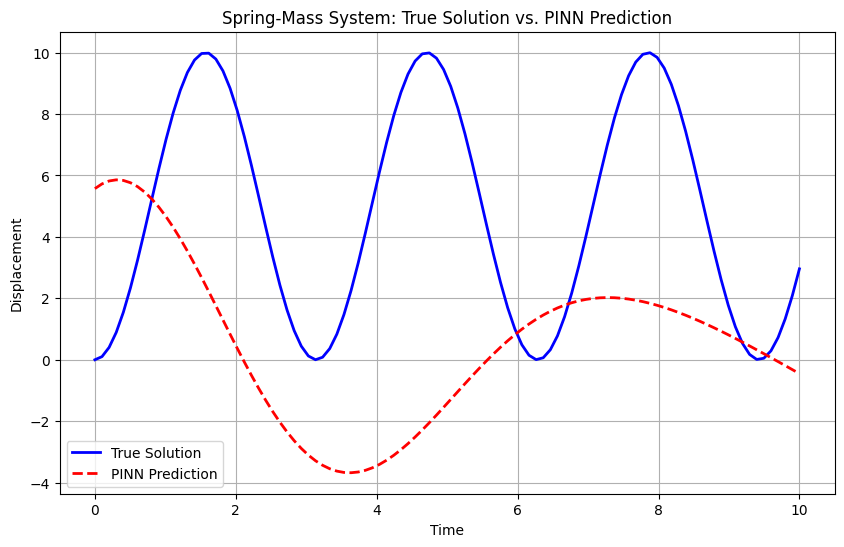

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

# Define the physics-informed neural network
class PhysicsInformedNN:
    def __init__(self, x, force, layers, m, c, k):
        self.x = x
        self.force = force
        self.m = m
        self.c = c
        self.k = k

        # Create the model
        self.model = PINN(layers)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def compute_loss(self, x, force):
        # Ensure we track gradients on x for physics-based loss
        x.requires_grad_(True)
        
        # Forward pass: add extra dimension for batch processing
        u_pred = self.model(x)
        
        # Compute first derivative
        du_dx = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
        
        # Compute second derivative
        d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]

        # Residual calculation (Physics loss)
        residual = self.m * d2u_dx2 + self.c * du_dx + self.k * u_pred - force
        return torch.mean(residual**2)

    def train(self, epochs):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.compute_loss(self.x, self.force)
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

    def predict(self, x):
        with torch.no_grad():
            return self.model(x).numpy()

# Define true solution (for comparison)
def true_solution(x, m, c, k, force, omega_f):
    omega_n = np.sqrt(k/m)  # Natural frequency
    zeta = c/(2*np.sqrt(k*m))  # Damping ratio
    A = force/(m*np.sqrt((omega_n**2 - omega_f**2)**2 + (2*zeta*omega_n*omega_f)**2))
    return A * np.sin(omega_f*x)

# Parameters for the system
m = 1.0  # Mass
c = 0.1  # Damping coefficient
k = 1.0  # Spring constant
omega_f = 1.0  # Forcing frequency

# Example data
x = torch.linspace(0, 10, 100).reshape(-1, 1)  # Time data
force = torch.sin(omega_f * x)  # External force as a sine wave

# Initialize and train the PINN
layers = [1, 20, 20, 20, 1]  # Network layers: input, hidden layers, output
pinn = PhysicsInformedNN(x, force, layers, m, c, k)
pinn.train(epochs=10000)

# Predict displacements using the trained model
x_numpy = x.detach().numpy()  # Detach x from computational graph before converting to numpy
u_pred = pinn.predict(x)
u_true = true_solution(x_numpy, m, c, k, force.detach().numpy(), omega_f)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_numpy, u_true, label='True Solution', color='blue', linewidth=2)
plt.plot(x_numpy, u_pred, label='PINN Prediction', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Spring-Mass System: True Solution vs. PINN Prediction')
plt.legend()
plt.grid(True)
plt.show()

Epoch 0, Loss: 0.4468632936477661
Epoch 100, Loss: 0.014878860674798489
Epoch 200, Loss: 0.0001316124980803579
Epoch 300, Loss: 0.00012517404684331268
Epoch 400, Loss: 4.7211506171151996e-05
Epoch 500, Loss: 3.943402407458052e-05
Epoch 600, Loss: 3.518490120768547e-05
Epoch 700, Loss: 3.424684109631926e-05
Epoch 800, Loss: 3.20292056130711e-05
Epoch 900, Loss: 3.682183159980923e-05
Epoch 1000, Loss: 0.0003160313644912094
Epoch 1100, Loss: 0.00021648136316798627
Epoch 1200, Loss: 3.8638445403194055e-05
Epoch 1300, Loss: 2.6048466679640114e-05
Epoch 1400, Loss: 2.703377504076343e-05
Epoch 1500, Loss: 2.487310666765552e-05
Epoch 1600, Loss: 6.410224887076765e-05
Epoch 1700, Loss: 2.575635699031409e-05
Epoch 1800, Loss: 2.3199974748422392e-05
Epoch 1900, Loss: 2.6563808205537498e-05


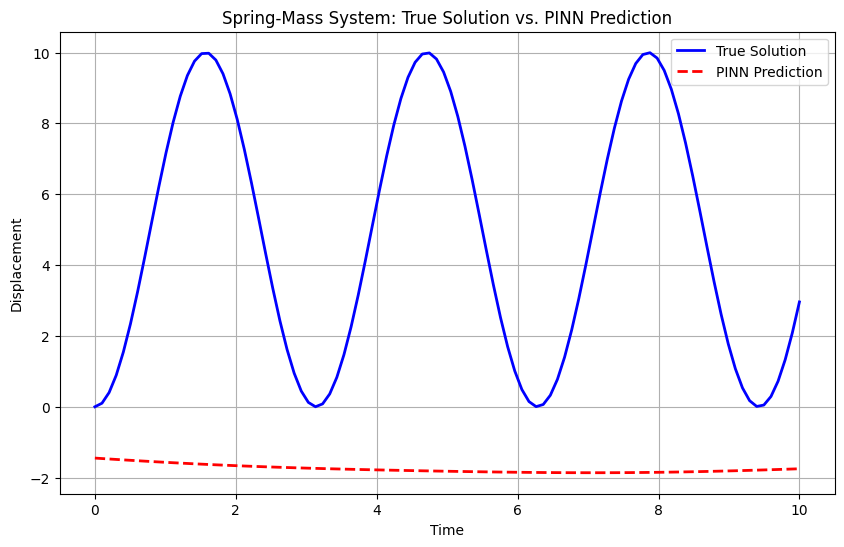

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))  # Activation function
        return self.layers[-1](x)

# Define the physics-informed neural network
class PhysicsInformedNN:
    def __init__(self, x, force, layers, m, c, k):
        self.x = x
        self.force = force
        self.m = m
        self.c = c
        self.k = k

        # Create the model
        self.model = PINN(layers)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def compute_loss(self, x, force):
        # Ensure we track gradients on x for physics-based loss
        x.requires_grad_(True)
        
        # Forward pass: add extra dimension for batch processing
        u_pred = self.model(x)
        
        # Compute first derivative
        du_dx = torch.autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
        
        # Compute second derivative
        d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]

        # Residual calculation (Physics loss)
        residual = self.m * d2u_dx2 + self.c * du_dx + self.k * u_pred - force
        return torch.mean(residual**2)

    def train(self, epochs):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.compute_loss(self.x, self.force)
            loss.backward()
            self.optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

    def predict(self, x):
        with torch.no_grad():
            return self.model(x).numpy()

# Define true solution (for comparison)
def true_solution(x, m, c, k, force, omega_f):
    omega_n = np.sqrt(k/m)  # Natural frequency
    zeta = c/(2*np.sqrt(k*m))  # Damping ratio
    A = force/(m*np.sqrt((omega_n**2 - omega_f**2)**2 + (2*zeta*omega_n*omega_f)**2))
    return A * np.sin(omega_f*x)

# Parameters for the system
m = 1.0  # Mass
c = 0.1  # Damping coefficient
k = 1.0  # Spring constant
omega_f = 1.0  # Forcing frequency

# Example data
x = torch.linspace(0, 10, 100).reshape(-1, 1)  # Time data
force = torch.sin(omega_f * x)  # External force as a sine wave

# Normalize input data
x_min, x_max = x.min(), x.max()
x_normalized = (x - x_min) / (x_max - x_min)

# Initialize and train the PINN
layers = [1, 40, 40, 40, 1]  # Increased network layers
pinn = PhysicsInformedNN(x_normalized, force, layers, m, c, k)
pinn.train(epochs=2000)  # Increased training epochs

# Predict displacements using the trained model
x_numpy = x.detach().numpy()
u_pred = pinn.predict(x_normalized)
u_true = true_solution(x_numpy, m, c, k, force.detach().numpy(), omega_f)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_numpy, u_true, label='True Solution', color='blue', linewidth=2)
plt.plot(x_numpy, u_pred, label='PINN Prediction', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Spring-Mass System: True Solution vs. PINN Prediction')
plt.legend()
plt.grid(True)
plt.show()